## **Introduction**

<img src="SamRize_Logo.png" width="200">

Notebook ini bertujuan untuk mengembangkan sistem ringkasan ulasan (**SamRize**) produk handphone Samsung dengan pendekatan Natural Language Processing (NLP menggunakan **Topic Modelling** (Unsupervised Machine Learning). Proses yang dilakukan dalam notebook ini meliputi:

- Melakukan Exploratory Data Analysis (EDA) untuk memahami karakteristik data ulasan handphone Samsung dari Amazon.
- Melakukan text preprocessing pada ulasan pengguna agar siap digunakan dalam proses pemodelan.
- Menerapkan algoritma FASTopic untuk mengekstrak topik utama dari teks ulasan secara unsupervised, tanpa pelabelan data.
- Memisahkan ulasan berdasarkan rating untuk mengidentifikasi **strength** dan **weakness** produk.
- Mengevaluasi kualitas topik yang dihasilkan menggunakan Coherence Score (c_v).
- Menghasilkan ringkasan topik yang merepresentasikan opini pengguna terhadap setiap tipe handphone Samsung.

Pendekatan yang digunakan dalam notebook ini berfokus pada topic modelling untuk mengekstrak insight utama dari ulasan pengguna, sehingga dapat membantu calon pembeli maupun pihak bisnis dalam memahami persepsi pengguna secara lebih efisien.


## **Library Import**

In [1]:
# Import library

import re
import nltk
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from fastopic import FASTopic
from topmost.preprocess import Preprocess

from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

from collections import Counter

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/kiki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Data Loading & Exploration**

#### **Data Loading**

In [2]:
df = pd.read_csv("Data_Scraped/clean.csv")

df.head(5)

,Unnamed: 0,title,price,battery,description,reviews,ratings,url,img_url,brand,...,cpu_speed,storage,screen_size,resolution,refresh_rate,model_name,weight_gr,rating_distribution,overall_rating,language
0,0,"Samsung Galaxy Z Fold7 Cell Phone, 512GB AI Sm...",2119.99,4400,"Expand what’s possible with Galaxy Z Fold7, th...",I’ve used Samsung’s Ultra and Note series for ...,5.0,https://www.amazon.com/Samsung-Smartphone-Unlo...,https://m.media-amazon.com/images/I/41yEZrL-vj...,Samsung,...,4.7,512,8.0,1968 x 2184,120,Galaxy Z Fold7,215.46,80%,4.5,en
1,0,"Samsung Galaxy Z Fold7 Cell Phone, 512GB AI Sm...",2119.99,4400,"Expand what’s possible with Galaxy Z Fold7, th...",This phone is worth every penny! I am upgradin...,5.0,https://www.amazon.com/Samsung-Smartphone-Unlo...,https://m.media-amazon.com/images/I/41yEZrL-vj...,Samsung,...,4.7,512,8.0,1968 x 2184,120,Galaxy Z Fold7,215.46,80%,4.5,en
2,0,"Samsung Galaxy Z Fold7 Cell Phone, 512GB AI Sm...",2119.99,4400,"Expand what’s possible with Galaxy Z Fold7, th...",I've been a lifelong Samsung user. I've had th...,5.0,https://www.amazon.com/Samsung-Smartphone-Unlo...,https://m.media-amazon.com/images/I/41yEZrL-vj...,Samsung,...,4.7,512,8.0,1968 x 2184,120,Galaxy Z Fold7,215.46,80%,4.5,en
3,0,"Samsung Galaxy Z Fold7 Cell Phone, 512GB AI Sm...",2119.99,4400,"Expand what’s possible with Galaxy Z Fold7, th...","So far, the item is great and very practical. ...",5.0,https://www.amazon.com/Samsung-Smartphone-Unlo...,https://m.media-amazon.com/images/I/41yEZrL-vj...,Samsung,...,4.7,512,8.0,1968 x 2184,120,Galaxy Z Fold7,215.46,80%,4.5,en
4,0,"Samsung Galaxy Z Fold7 Cell Phone, 512GB AI Sm...",2119.99,4400,"Expand what’s possible with Galaxy Z Fold7, th...",Switched from iOS to android with this purchas...,5.0,https://www.amazon.com/Samsung-Smartphone-Unlo...,https://m.media-amazon.com/images/I/41yEZrL-vj...,Samsung,...,4.7,512,8.0,1968 x 2184,120,Galaxy Z Fold7,215.46,80%,4.5,en


#### **Data Exploration**

In [3]:
df.columns

Index(['Unnamed: 0', 'title', 'price', 'battery', 'description', 'reviews',
       'ratings', 'url', 'img_url', 'brand', 'os', 'ram', 'cpu_model',
       'cpu_speed', 'storage', 'screen_size', 'resolution', 'refresh_rate',
       'model_name', 'weight_gr', 'rating_distribution', 'overall_rating',
       'language'],
      dtype='object')

In [4]:
df.shape

(817, 23)

Pada tahap data exploration, dataset yang digunakan berisi informasi produk smartphone beserta spesifikasi teknis dan ulasan pengguna. Setiap baris merepresentasikan satu produk dengan atribut seperti title, brand, price, battery, RAM, storage, CPU, screen size, dan spesifikasi hardware lainnya.

Selain fitur produk, terdapat kolom reviews dan ratings yang menjadi fokus utama dalam analisis NLP. Kolom reviews berisi teks ulasan pengguna, sedangkan ratings berisi skor penilaian numerik yang kemudian digunakan untuk mengelompokkan sentimen menjadi strength dan weakness.

Secara keseluruhan, dataset ini memungkinkan analisis gabungan antara aspek produk (spesifikasi) dan opini pengguna (teks review), sehingga cocok untuk exploratory data analysis, sentiment analysis, dan topic modeling untuk ringkasan ulasan.

In [5]:
# Drop unecessary column

df = df.drop(columns=['Unnamed: 0'])

In [6]:
df["model_name"].value_counts()

model_name
Galaxy Note 20 Ultra 5G        50
Galaxy Z Fold7                 49
Galaxy S23                     49
Galaxy S25 FE                  48
Galaxy Note 10 Plus            48
Galaxy S24 5G                  48
Samsung Galaxy S23 FE          47
Galaxy S23+ 5G                 46
Galaxy Z Flip 4                46
Galaxy Z Fold 4                45
Galaxy Z Flip5 5G              45
Galaxy S22 Ultra 5G            45
Samsung S22+                   42
Samsung Galaxy S23 Ultra 5G    39
Galaxy S25                     38
Samsung Galaxy S24 Ultra 5G    33
Samsung Galaxy Z Flip 6        32
Samsung Galaxy Fold 6          28
Galaxy S25 Ultra               26
Galaxy Z Flip7 FE              13
Name: count, dtype: int64

Distribusi jumlah review per model menunjukkan bahwa sebagian besar smartphone memiliki jumlah ulasan yang relatif mirip, berada pada kisaran 40–50 review. Namun, terdapat beberapa model dengan jumlah review yang lebih sedikit, bahkan di bawah 30, sehingga distribusinya belum sepenuhnya seimbang.

Ketidakseimbangan ini terjadi karena adanya keterbatasan pada proses scraping, sehingga tidak semua produk berhasil dikumpulkan dengan jumlah review yang sama. Meski demikian, secara umum setiap model masih memiliki cukup data untuk dilakukan analisis sentimen dan eksplorasi teks.

#### **Review Labelling**

In [7]:
# classify reviews based on rating
def review_category(r):
    if r <= 3:
        return "weakness"
    else:
        return "strength"

df["review_type"] = df["ratings"].apply(review_category)

# check distribution
df["review_type"].value_counts()


review_type
weakness    478
strength    339
Name: count, dtype: int64

In [8]:
# split dataset into two groups
df_strength = df[df["review_type"] == "strength"].copy()
df_weakness = df[df["review_type"] == "weakness"].copy()

Pada tahap ini, reviews diklasifikasikan berdasarkan nilai rating untuk memisahkan sentimen secara sederhana. Rating 1–3 dikelompokkan sebagai weakness yang merepresentasikan keluhan atau ketidakpuasan pengguna, sedangkan rating 4–5 dikategorikan sebagai strength yang merepresentasikan pengalaman positif atau kelebihan produk.

Namun, perlu diperhatikan bahwa rating 3 berada pada grey area, karena dapat bersifat netral atau berisi kritik ringan, sehingga tidak sepenuhnya merepresentasikan sentimen negatif. Meskipun demikian, pada analisis ini rating 3 tetap dimasukkan ke dalam kategori weakness untuk menyederhanakan proses segmentasi sentimen awal.

Hasil pengelompokan menunjukkan bahwa jumlah weakness reviews (478) lebih banyak dibandingkan strength reviews (339), yang mengindikasikan bahwa pengguna lebih sering memberikan ulasan saat mengalami masalah.

Selanjutnya, dataset dipisahkan menjadi dua subset, yaitu df_strength dan df_weakness, agar analisis eksplorasi teks dan pemodelan NLP berikutnya dapat dilakukan secara terpisah sehingga insight yang diperoleh lebih spesifik dan informatif untuk masing-masing kategori.

## **Exploratory Data Analysis (EDA) - Before Preprocessing**

#### **Strength & Weakness Distribution**

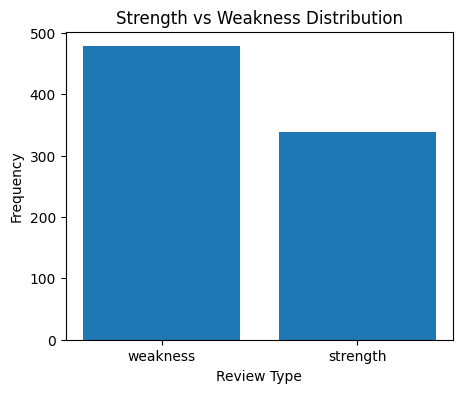

In [9]:
# count each category
counts = df["review_type"].value_counts()

plt.figure(figsize=(5,4))
plt.bar(counts.index, counts.values)
plt.xlabel("Review Type")
plt.ylabel("Frequency")
plt.title("Strength vs Weakness Distribution")
plt.show()

EDA ini dilakukan pada tahap awal menggunakan raw reviews sebelum text preprocessing.

Grafik menunjukkan bahwa jumlah weakness reviews (478) lebih banyak dibandingkan strength reviews (339). Hal ini mengindikasikan bahwa pengguna cenderung lebih sering menulis ulasan ketika mengalami masalah dibandingkan saat merasa puas.

Distribusi ini penting sebagai dasar analisis NLP selanjutnya, sehingga data dipisahkan menjadi dua kelompok (strength dan weakness) agar insight yang dihasilkan lebih spesifik dan representatif.

#### **Sentence Count**

In [10]:
# count number of sentences in each review
def count_sentences(text):
    sentences = re.split(r"[.!?]+", text)
    sentences = [s for s in sentences if s.strip()]
    return len(sentences)

In [11]:
# apply sentence count to both groups
df_strength["sentence_count"] = df_strength["reviews"].apply(count_sentences)
df_weakness["sentence_count"] = df_weakness["reviews"].apply(count_sentences)

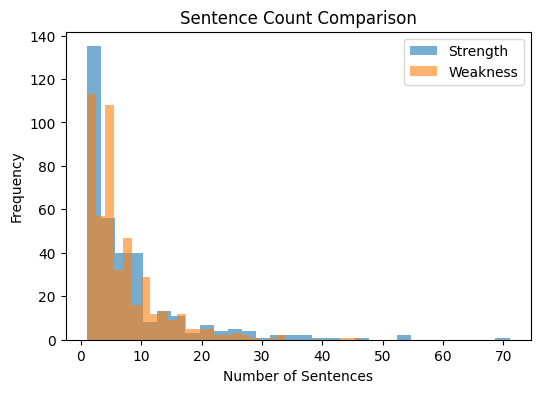

In [12]:
plt.figure(figsize=(6,4))
plt.hist(df_strength["sentence_count"], bins=30, alpha=0.6, label="Strength")
plt.hist(df_weakness["sentence_count"], bins=30, alpha=0.6, label="Weakness")

plt.xlabel("Number of Sentences")
plt.ylabel("Frequency")
plt.title("Sentence Count Comparison")
plt.legend()

plt.show()

Distribusi jumlah kalimat menunjukkan bahwa sebagian besar review, baik strength maupun weakness, terdiri dari sedikit kalimat, umumnya kurang dari 10 kalimat. Hal ini mengindikasikan bahwa mayoritas pengguna menulis ulasan yang singkat dan langsung pada inti pengalaman mereka.

Namun, terlihat bahwa weakness reviews cenderung memiliki sebaran yang sedikit lebih panjang dibandingkan strength reviews, dengan beberapa outlier yang memiliki jumlah kalimat cukup banyak. Pola ini menunjukkan bahwa pengguna biasanya memberikan penjelasan lebih detail saat menyampaikan keluhan atau masalah, sedangkan ulasan positif cenderung lebih ringkas.

Temuan ini cukup penting karena panjang teks dapat memengaruhi proses NLP selanjutnya, seperti topic modeling atau sentiment analysis, di mana review yang lebih panjang berpotensi mengandung lebih banyak informasi atau aspek produk.

#### **Word Count**

In [13]:
# count number of words in each review
def count_words(text):
    return len(text.split())

In [14]:
# compute word count for both groups
df_strength["word_count"] = df_strength["reviews"].apply(count_words)
df_weakness["word_count"] = df_weakness["reviews"].apply(count_words)

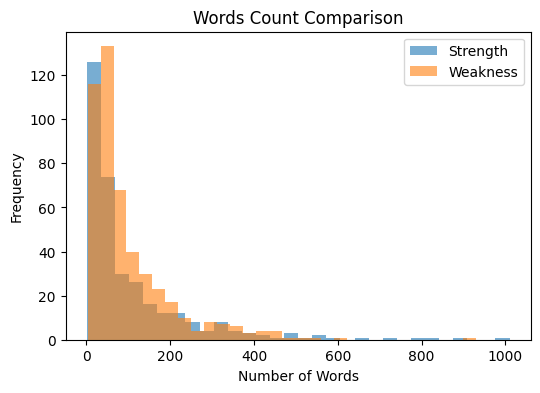

In [15]:
plt.figure(figsize=(6,4))
plt.hist(df_strength["word_count"], bins=30, alpha=0.6, label="Strength")
plt.hist(df_weakness["word_count"], bins=30, alpha=0.6, label="Weakness")

plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Words Count Comparison")
plt.legend()

plt.show()

Distribusi jumlah kata menunjukkan bahwa sebagian besar review memiliki panjang teks yang relatif pendek, dengan mayoritas berada di bawah 100 kata. Hal ini menandakan bahwa pengguna umumnya memberikan ulasan secara singkat dan langsung.

Namun, weakness reviews cenderung memiliki jumlah kata yang lebih banyak serta sebaran yang lebih lebar dibandingkan strength reviews. Terdapat beberapa review negatif yang sangat panjang (outlier), yang mengindikasikan bahwa pengguna biasanya menjelaskan keluhan atau masalah secara lebih detail.

Temuan ini memperkuat pola sebelumnya pada sentence count, di mana ulasan negatif mengandung informasi yang lebih kaya. Kondisi ini bermanfaat untuk analisis NLP lanjutan seperti topic modeling atau aspect extraction, karena review yang lebih panjang berpotensi memberikan lebih banyak insight terkait masalah produk.

#### **Wordcloud**

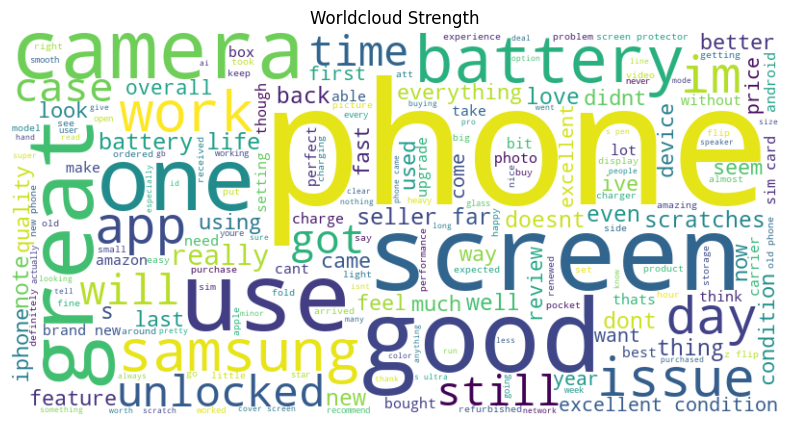

In [16]:
# Strength

text = ' '.join(df[df["review_type"] == "strength"]["reviews"].astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', '', text)
text = text.lower()
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Worldcloud Strength")
plt.show()

Wordcloud pada strength reviews menampilkan kata-kata positif dan apresiatif yang paling sering muncul, seperti great, good, phone, camera, battery, dan feature. Kata-kata ini menunjukkan bahwa pengguna umumnya menyoroti kualitas produk, performa, serta fitur utama sebagai kelebihan.

Beberapa istilah seperti battery, camera, screen, dan performance juga cukup dominan, mengindikasikan bahwa aspek teknis menjadi faktor utama kepuasan pengguna. Selain itu, kata-kata seperti love, fast, dan recommend mencerminkan pengalaman positif serta tingkat kepuasan yang tinggi.

Secara keseluruhan, strength reviews cenderung berfokus pada pujian terhadap performa dan fitur produk, sehingga dapat dimanfaatkan untuk mengidentifikasi selling points atau keunggulan utama dari masing-masing smartphone.

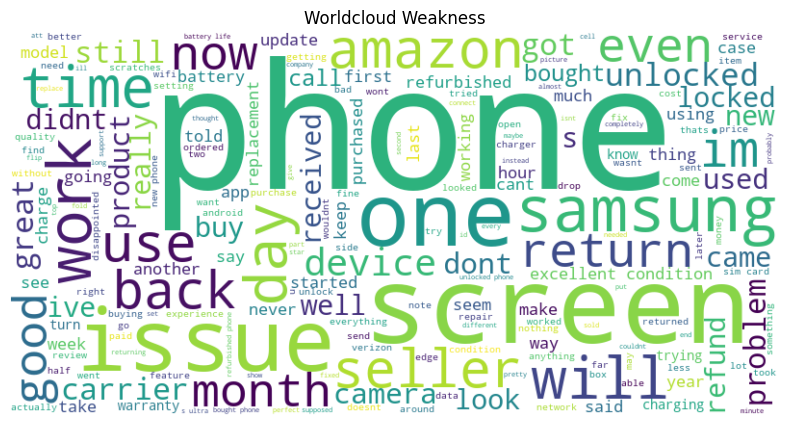

In [17]:
# Weakness

text = ' '.join(df[df["review_type"] == "weakness"]["reviews"].astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', '', text)
text = text.lower()
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Worldcloud Weakness")
plt.show()

Wordcloud pada weakness reviews didominasi oleh kata-kata bernuansa masalah atau keluhan, seperti issue, problem, return, refund, locked, dan time. Hal ini menunjukkan bahwa sebagian besar pengguna menyampaikan pengalaman negatif terkait kendala penggunaan, proses pengembalian barang, atau ketidakpuasan terhadap kondisi produk.

Beberapa kata seperti unlocked, refurbished, seller, dan device juga cukup menonjol, yang mengindikasikan bahwa keluhan tidak hanya terkait performa perangkat, tetapi juga aspek non-teknis seperti kualitas produk bekas, kondisi fisik, atau layanan penjual.

Secara keseluruhan, weakness reviews cenderung lebih berfokus pada masalah operasional dan pengalaman pasca-pembelian. Insight ini penting untuk mengidentifikasi pain points utama pengguna yang dapat menjadi dasar perbaikan produk maupun layanan.

## **Text Preprocessing**

Setelah melakukan exploratory data analysis (EDA) terhadap distribusi review, panjang teks, serta pola kata pada masing-masing kategori strength dan weakness, langkah selanjutnya adalah melakukan text preprocessing.

Tahap ini bertujuan untuk membersihkan dan menormalkan teks mentah (raw reviews) agar lebih terstruktur dan siap digunakan pada proses analisis NLP lanjutan. Data teks asli biasanya masih mengandung noise seperti tanda baca, angka, URL, karakter khusus, serta kata-kata umum (stopwords) yang tidak memberikan makna penting.

Melalui text preprocessing, konten review akan diubah menjadi format yang lebih bersih dan konsisten sehingga dapat meningkatkan kualitas fitur teks, mengurangi dimensi kata yang tidak relevan, serta membantu model seperti topic modeling, sentiment analysis, dan sistem rekomendasi menghasilkan insight yang lebih akurat.

In [18]:
# Base english stopwords
base_stopwords = set(nltk_stopwords.words("english"))

lemmatizer = WordNetLemmatizer()

# Domain-specific stopwords (ecommerce + generic + device words)
custom_stopwords = {
    # ecommerce / marketplace noise
    "amazon","seller","ship","shipping","delivery","arrive","arrived",
    "order","return","refund","warranty","replace","replacement",
    "customer","service","support","deal","price","money","buy","bought","purchase",
    "condition","new","used","renewed","refurbished","refurbish",
    "packaging","box","package","asurion",

    # carrier / network
    "verizon","tmobile","att","carrier","sim","imei","unlocked","locked",

    # brand / device generic
    "samsung","galaxy","phone","device","smartphone","mobile",

    # generic opinion words
    "good","great","nice","awesome","excellent","perfect","ok","okay",
    "love","like","really","pretty","fine",

    # filler words
    "thing","things","stuff",
    "use","using","used","work","works","working",
    "get","got","one","also","would","could",

    # add
    "day","days","week","weeks","month","months","year","years",
    "time","times","first","last","next","every",
    "say","said","tell","told",
    "take","make","come","go","back","even","still",
    "look","see","know","want","need","try","seem"}

# merge stopwords
stop_words = base_stopwords | custom_stopwords

lemmatizer = WordNetLemmatizer()


In [19]:
def get_wordnet_pos(tag):
    # Convert POS tag for WordNet lemmatizer
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def text_preprocessing(text):
    # Handle missing value
    if pd.isna(text):
        return ""

    # Lowercase
    text = str(text).lower()

    # Remove urls and html
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"<.*?>", " ", text)

    # Keep only alphabetic characters
    text = re.sub(r"[^a-z\s]", " ", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize
    tokens = text.split()

    # Remove stopwords and short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    if not tokens:
        return ""

    # POS tagging
    tagged = pos_tag(tokens)

    # Lemmatize with POS
    tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(p)) for w, p in tagged]

    # Remove stopwords again after lemmatization
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    # Return clean string
    return " ".join(tokens)

Proses dimulai dengan penggunaan stopwords bahasa Inggris standar yang kemudian dikombinasikan dengan custom stopwords berbasis domain e-commerce dan perangkat smartphone, seperti seller, shipping, refurbished, samsung, phone, dan kata-kata generik seperti good atau great. Penghapusan kata-kata ini bertujuan agar model lebih fokus pada aspek penting produk, bukan kata umum atau konteks transaksi.

Selanjutnya, teks dinormalisasi melalui lowercase, penghapusan URL, HTML tag, karakter non-alfabet, serta whitespace berlebih. Setelah itu dilakukan tokenisasi, penghapusan stopwords dan kata terlalu pendek, kemudian lemmatization berbasis POS tagging untuk mengembalikan kata ke bentuk dasarnya sehingga variasi kata dengan makna sama dapat disatukan.

Hasil akhir dari proses ini adalah teks yang lebih ringkas, bersih, dan informatif.


In [20]:
# Apply text preprocessing to DataFrame

df["review_clean"] = df["reviews"].astype(str).apply(text_preprocessing)

In [21]:
df_strength = df[df["review_type"]=="strength"].copy()
df_weakness = df[df["review_type"]=="weakness"].copy()

In [22]:
df_strength

,title,price,battery,description,reviews,ratings,url,img_url,brand,os,...,screen_size,resolution,refresh_rate,model_name,weight_gr,rating_distribution,overall_rating,language,review_type,review_clean
0,"Samsung Galaxy Z Fold7 Cell Phone, 512GB AI Sm...",2119.99,4400,"Expand what’s possible with Galaxy Z Fold7, th...",I’ve used Samsung’s Ultra and Note series for ...,5.0,https://www.amazon.com/Samsung-Smartphone-Unlo...,https://m.media-amazon.com/images/I/41yEZrL-vj...,Samsung,"Android 16, OneUI 8",...,8.0,1968 x 2184,120,Galaxy Z Fold7,215.46,80%,4.5,en,strength,ultra note series familiar wide boxy large dis...
1,"Samsung Galaxy Z Fold7 Cell Phone, 512GB AI Sm...",2119.99,4400,"Expand what’s possible with Galaxy Z Fold7, th...",This phone is worth every penny! I am upgradin...,5.0,https://www.amazon.com/Samsung-Smartphone-Unlo...,https://m.media-amazon.com/images/I/41yEZrL-vj...,Samsung,"Android 16, OneUI 8",...,8.0,1968 x 2184,120,Galaxy Z Fold7,215.46,80%,4.5,en,strength,worth penny upgrade old non flagship flip upgr...
2,"Samsung Galaxy Z Fold7 Cell Phone, 512GB AI Sm...",2119.99,4400,"Expand what’s possible with Galaxy Z Fold7, th...",I've been a lifelong Samsung user. I've had th...,5.0,https://www.amazon.com/Samsung-Smartphone-Unlo...,https://m.media-amazon.com/images/I/41yEZrL-vj...,Samsung,"Android 16, OneUI 8",...,8.0,1968 x 2184,120,Galaxy Z Fold7,215.46,80%,4.5,en,strength,lifelong user note fold switch flip fold scree...
3,"Samsung Galaxy Z Fold7 Cell Phone, 512GB AI Sm...",2119.99,4400,"Expand what’s possible with Galaxy Z Fold7, th...","So far, the item is great and very practical. ...",5.0,https://www.amazon.com/Samsung-Smartphone-Unlo...,https://m.media-amazon.com/images/I/41yEZrL-vj...,Samsung,"Android 16, OneUI 8",...,8.0,1968 x 2184,120,Galaxy Z Fold7,215.46,80%,4.5,en,strength,far item practical main display slightly frail...
4,"Samsung Galaxy Z Fold7 Cell Phone, 512GB AI Sm...",2119.99,4400,"Expand what’s possible with Galaxy Z Fold7, th...",Switched from iOS to android with this purchas...,5.0,https://www.amazon.com/Samsung-Smartphone-Unlo...,https://m.media-amazon.com/images/I/41yEZrL-vj...,Samsung,"Android 16, OneUI 8",...,8.0,1968 x 2184,120,Galaxy Z Fold7,215.46,80%,4.5,en,strength,switch android pleased easy connect esim favor...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,"Samsung Galaxy S23 FE 5G, US Version, 128GB, B...",218.75,4500,Introducing the Samsung Galaxy S23 FE SM-S711U...,Small scuffs on the front edges but nothing ma...,4.0,https://www.amazon.com/Samsung-Galaxy-Version-...,https://m.media-amazon.com/images/I/51l6YHB2x4...,Samsung,Android,...,6.4,2340 x 1080,120,Samsung Galaxy S23 FE,209.79,13%,4.3,en,strength,small scuff front edge nothing major hardly no...
786,"Samsung Galaxy S23 FE 5G, US Version, 128GB, B...",218.75,4500,Introducing the Samsung Galaxy S23 FE SM-S711U...,My 2nd Samsung cellphone and the first time I'...,4.0,https://www.amazon.com/Samsung-Galaxy-Version-...,https://m.media-amazon.com/images/I/51l6YHB2x4...,Samsung,Android,...,6.4,2340 x 1080,120,Samsung Galaxy S23 FE,209.79,13%,4.3,en,strength,cellphone type reasonably promptly switch card...
787,"Samsung Galaxy S23 FE 5G, US Version, 128GB, B...",218.75,4500,Introducing the Samsung Galaxy S23 FE SM-S711U...,"Phone was unlocked, just needed a sim to get t...",4.0,https://www.amazon.com/Samsung-Galaxy-Version-...,https://m.media-amazon.com/images/I/51l6YHB2x4...,Samsung,Android,...,6.4,2340 x 1080,120,Samsung Galaxy S23 FE,209.79,13%,4.3,en,strength,straight talk issue function performance give ...
788,"Samsung Galaxy S23 FE 5G, US Version, 128GB, B...",218.75,4500,Introducing the Samsung Galaxy S23 FE SM-S711U...,DOES NOT INCLUDE A CHARGER! Otherwise as expe...,4.0,https://www.amazon.com/Samsung-Galaxy-Version-...,https://m.media-amazon.com/images/I/51l6YHB2x4...,Samsung,Android,...,6.4,2340 x 1080,120,Samsung Galaxy S23 FE,209.79,13%,4.3,en,strength,include charger othe

## **Exploratory Data Analysis (EDA) - After Preprocessing**

## **Topic Modelling**

#### **Word Count**

In [23]:
# apply to clean reviews
df_strength["word_count_clean"] = df_strength["review_clean"].apply(count_words)
df_weakness["word_count_clean"] = df_weakness["review_clean"].apply(count_words)

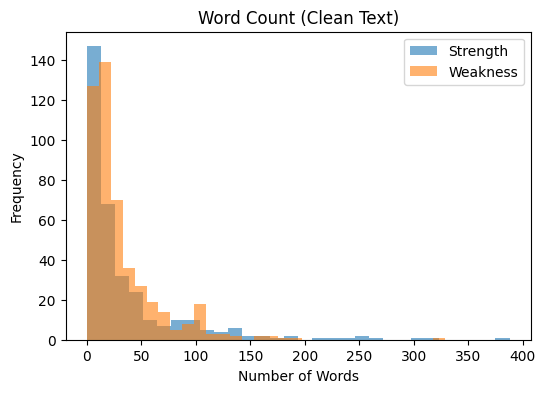

In [24]:
# compare word distribution after cleaning
plt.figure(figsize=(6,4))

plt.hist(df_strength["word_count_clean"], bins=30, alpha=0.6, label="Strength")
plt.hist(df_weakness["word_count_clean"], bins=30, alpha=0.6, label="Weakness")

plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Word Count (Clean Text)")
plt.legend()

plt.show()

#### **Wordcloud**

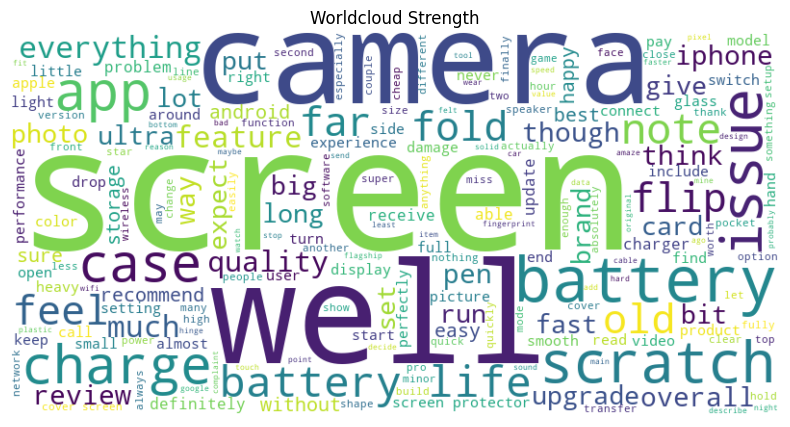

In [25]:
# Strength

text = ' '.join(df_strength["review_clean"].astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', '', text)
text = text.lower()
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Worldcloud Strength")
plt.show()

Wordcloud pada strength reviews setelah text preprocessing menampilkan kata-kata yang lebih spesifik dan informatif dibandingkan sebelumnya. Kata-kata umum atau noise seperti nama brand, istilah transaksi, dan stopwords telah berkurang, sehingga aspek produk yang benar-benar penting menjadi lebih menonjol.

Terlihat bahwa kata seperti screen, camera, battery, charge, fast, feature, dan quality muncul lebih dominan, yang menunjukkan bahwa pengguna banyak memberikan apresiasi terhadap performa layar, kualitas kamera, daya tahan baterai, serta fitur perangkat secara keseluruhan.

Hasil ini menunjukkan bahwa proses preprocessing berhasil menghilangkan kata tidak relevan dan membantu menyoroti selling points utama produk, sehingga insight yang diperoleh menjadi lebih jelas dan lebih berguna untuk analisis lanjutan seperti topic modeling atau aspect-based analysis.

#### **Weakness**

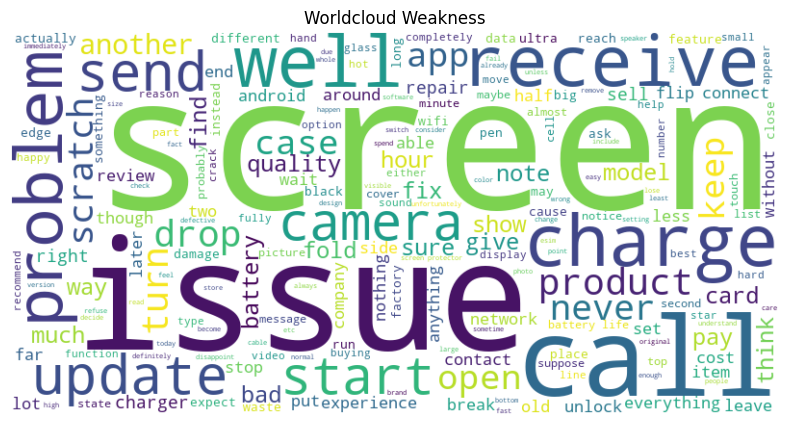

In [26]:
# Weakness

text = ' '.join(df_weakness["review_clean"].astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', '', text)
text = text.lower()
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Worldcloud Weakness")
plt.show()

Wordcloud pada weakness reviews setelah text preprocessing memperlihatkan kata-kata yang lebih terfokus pada masalah dan keluhan pengguna. Setelah noise dan kata umum dihapus, istilah yang muncul menjadi lebih spesifik dan merepresentasikan pain points utama.

Kata seperti screen, issue, problem, return, fix, receive, call, charge, dan repair terlihat dominan, yang menunjukkan bahwa keluhan banyak berkaitan dengan kerusakan perangkat, kendala baterai atau pengisian daya, serta proses layanan purna jual seperti pengembalian atau perbaikan.

Dibandingkan strength reviews yang menonjolkan fitur dan performa, weakness reviews lebih menekankan pengalaman negatif dan hambatan penggunaan. Insight ini penting untuk mengidentifikasi area perbaikan produk maupun layanan serta menjadi dasar analisis lanjutan seperti complaint clustering atau topic modeling.

## **Model Building**

#### **Split Dataset Based on Handphone Model**

Setelah tahap exploratory data analysis dan text preprocessing selesai, proses dilanjutkan ke tahap model building. Pada tahap ini, data mulai disusun dalam struktur yang lebih terorganisir agar analisis dapat dilakukan secara lebih spesifik dan terfokus.

Langkah pertama adalah mengelompokkan dataset berdasarkan model_name, sehingga setiap smartphone memiliki kumpulan review masing-masing. Dengan pemisahan ini, analisis dapat dilakukan per produk untuk mengidentifikasi pola opini, kelebihan, dan kekurangan secara lebih detail.

Hasil pengelompokan disimpan dalam bentuk dictionary, di mana setiap key merepresentasikan nama model smartphone dan value berisi subset DataFrame khusus untuk model tersebut.

In [27]:
grouped_df = {
    model: df_model.copy()
    for model, df_model in df.groupby("model_name")}

In [28]:
df['model_name'].value_counts()

model_name
Galaxy Note 20 Ultra 5G        50
Galaxy Z Fold7                 49
Galaxy S23                     49
Galaxy S25 FE                  48
Galaxy Note 10 Plus            48
Galaxy S24 5G                  48
Samsung Galaxy S23 FE          47
Galaxy S23+ 5G                 46
Galaxy Z Flip 4                46
Galaxy Z Fold 4                45
Galaxy Z Flip5 5G              45
Galaxy S22 Ultra 5G            45
Samsung S22+                   42
Samsung Galaxy S23 Ultra 5G    39
Galaxy S25                     38
Samsung Galaxy S24 Ultra 5G    33
Samsung Galaxy Z Flip 6        32
Samsung Galaxy Fold 6          28
Galaxy S25 Ultra               26
Galaxy Z Flip7 FE              13
Name: count, dtype: int64

#### **Modelling Definition**

Pada tahap model definition, terlebih dahulu dilakukan inisialisasi beberapa parameter utama untuk mengatur proses topic modeling:

- vocab_size = 4000: membatasi jumlah kosakata maksimum agar model hanya menggunakan kata yang paling sering dan relevan, sehingga mengurangi noise, mempercepat komputasi, dan mencegah dimensi fitur terlalu besar  
- num_topics = 5: jumlah topik dibuat relatif kecil agar hasil topik lebih ringkas, mudah diinterpretasikan, dan sesuai dengan ukuran data review per produk yang tidak terlalu besar  
- min_docs = 3: menetapkan jumlah minimum dokumen agar model hanya dilatih ketika data cukup representatif, sehingga menghindari topik yang tidak stabil akibat jumlah review yang terlalu sedikit  
- topic_results: dictionary untuk menyimpan hasil topik dan distribusi tiap model secara terstruktur  
- fastopic_models: dictionary untuk menyimpan objek FASTopic yang telah dilatih jika ingin digunakan kembali  
- preprocess_shared: konfigurasi preprocessing bersama agar seluruh model menggunakan pipeline yang konsisten  

Selanjutnya, proses pemodelan dijalankan menggunakan looping pada setiap model smartphone di grouped_df. Pada setiap iterasi, review dipisahkan menjadi strength dan weakness, kemudian FASTopic dilatih secara terpisah untuk masing-masing kategori. Pendekatan looping ini membuat proses lebih efisien, konsisten, dan mudah diskalakan karena seluruh produk dapat diproses secara otomatis tanpa penanganan manual satu per satu.

In [29]:
# config
vocab_size = 4000
num_topics = 5
min_docs = 3

topic_results = {}
fastopic_models = {}

# shared preprocess (default settings only)
preprocess_shared = Preprocess(
    vocab_size=vocab_size
)

for model_name, df_model in grouped_df.items():

    topic_results[model_name] = {"strength": {}, "weakness": {}}
    fastopic_models[model_name] = {"strength": None, "weakness": None}

    df_strength = df_model[df_model["review_type"] == "strength"]
    df_weakness = df_model[df_model["review_type"] == "weakness"]

    docs_strength = df_strength["review_clean"].dropna().astype(str).tolist()
    docs_weakness = df_weakness["review_clean"].dropna().astype(str).tolist()

    # strength
    if len(docs_strength) >= min_docs:
        model_strength = FASTopic(
            num_topics=num_topics,
            preprocess=preprocess_shared,
            verbose=False
        )

        topic_words_strength, doc_topic_strength = model_strength.fit_transform(docs_strength)

        # save model object for visualization later
        fastopic_models[model_name]["strength"] = model_strength

        topic_results[model_name]["strength"] = {
            "n_docs": len(docs_strength),
            "topic_words": topic_words_strength,
            "doc_topic": doc_topic_strength
        }
    else:
        topic_results[model_name]["strength"] = {
            "n_docs": len(docs_strength),
            "note": "not enough docs"
        }

    # weakness
    if len(docs_weakness) >= min_docs:
        model_weakness = FASTopic(
            num_topics=num_topics,
            preprocess=preprocess_shared,
            verbose=False
        )

        topic_words_weakness, doc_topic_weakness = model_weakness.fit_transform(docs_weakness)

        # save model object for visualization later
        fastopic_models[model_name]["weakness"] = model_weakness

        topic_results[model_name]["weakness"] = {
            "n_docs": len(docs_weakness),
            "topic_words": topic_words_weakness,
            "doc_topic": doc_topic_weakness
        }
    else:
        topic_results[model_name]["weakness"] = {
            "n_docs": len(docs_weakness),
            "note": "not enough docs"
        }

parsing texts: 100%|██████████| 20/20 [00:00<00:00, 19209.09it/s]
/opt/anaconda3/envs/h8_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

2026-02-06 07:17:29,853 - TopMost - Real vocab size: 583
2026-02-06 07:17:29,854 - TopMost - Real training size: 20 	 avg length: 54.400
parsing texts: 100%|██████████| 28/28 [00:00<00:00, 13053.30it/s]
2026-02-06 07:17:37,954 - TopMost - Real vocab size: 515
2026-02-06 07:17:37,956 - TopMost - Real training size: 28 	 avg length: 28.357
parsing texts: 100%|██████████| 20/20 [00:00<00:00, 8803.24it/s]
/opt/anaconda3/envs/h8_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

2026-02-06 07:17:45,025 - TopMost - Real vocab size: 481
2026-02-06 07:17:45,025 - TopMost - Real training size: 20 	 avg length: 39.650
parsing texts: 1

#### **Topic Visualization**

In [30]:
selected_models = list(grouped_df.keys())[:3]

In [31]:
# Strength

for model_name in selected_models:

    fastopic_model_strength = fastopic_models[model_name]["strength"]

    fig = fastopic_model_strength.visualize_topic(top_n=5)
    fig.update_layout(
        title_text=f"Topic-Word Distribution (Strength) - {model_name}",
        title_x=0.5
    )
    fig.show()

In [32]:
# Weakness

for model_name in selected_models:

    fastopic_model_weakness = fastopic_models[model_name]["weakness"]

    fig = fastopic_model_weakness.visualize_topic(top_n=5)
    fig.update_layout(
        title_text=f"Topic-Word Distribution (Weakness) - {model_name}",
        title_x=0.5)
    fig.show()

#### **Model Evaluation**

Pada tahap model evaluation, digunakan metode topic coherence dengan metrik c_v menggunakan library Gensim untuk mengevaluasi kualitas topik yang dihasilkan oleh FASTopic. Gensim dipilih karena menyediakan CoherenceModel yang umum digunakan dalam evaluasi topic modeling dan mampu mengukur keterkaitan semantik antar kata dalam satu topik berdasarkan kemunculan bersama (co-occurrence) di dalam dokumen. Pendekatan ini membantu memastikan bahwa topik yang dihasilkan lebih bermakna dan mudah diinterpretasikan.

Beberapa langkah yang dilakukan:

- Menggunakan Gensim CoherenceModel dengan metrik coherence c_v sebagai ukuran kualitas topik  
- Membuat fungsi normalize_topic_words untuk menyeragamkan format topic_words menjadi list[list[str]] agar kompatibel dengan Gensim  
- Melakukan looping pada setiap model smartphone di grouped_df sehingga evaluasi berjalan otomatis untuk seluruh produk  
- Mengambil teks review_clean dan melakukan tokenisasi (split kata) sebagai input perhitungan coherence  
- Membuat dictionary menggunakan Gensim untuk memetakan kata ke representasi numerik  
- Menetapkan batas minimum dokumen yang lebih ketat (min_docs_coh = 4) agar skor coherence lebih stabil dan tidak bias karena data terlalu sedikit  
- Menghitung skor coherence secara terpisah untuk strength dan weakness  
- Menyimpan hasil skor coherence_c_v kembali ke topic_results untuk memudahkan perbandingan kualitas topik antar model  

Dengan pendekatan ini, setiap model smartphone memiliki metrik evaluasi kuantitatif yang dapat digunakan untuk memastikan bahwa topik yang dihasilkan relevan, konsisten, dan mudah dipahami.

In [33]:
def normalize_topic_words(topic_words):
    
    """
    Menyeragamkan format topic words menjadi list[list[str]].

    Output FASTopic bisa berupa list token atau string.
    Fungsi ini memastikan semua topik berbentuk list token
    agar kompatibel dengan Gensim CoherenceModel.
    """

    if topic_words is None or len(topic_words) == 0:
        return []

    first = topic_words[0]

    # already tokenized
    if isinstance(first, (list, tuple, np.ndarray)):
        return [list(t) for t in topic_words]

    # string -> split
    return [str(t).split() for t in topic_words]

In [34]:
# Coherence evaluation

min_docs_coh = 4   # threshold for coherence only

for model_name, df_model in grouped_df.items():

    strength_data = topic_results.get(model_name, {}).get("strength", {})
    weakness_data = topic_results.get(model_name, {}).get("weakness", {})

    # skip if FASTopic not trained
    if "topic_words" not in strength_data or "topic_words" not in weakness_data:
        continue

    df_strength = df_model[df_model["review_type"] == "strength"]
    df_weakness = df_model[df_model["review_type"] == "weakness"]

    texts_strength = df_strength["review_clean"].dropna().astype(str).apply(lambda x: x.split()).tolist()
    texts_weakness = df_weakness["review_clean"].dropna().astype(str).apply(lambda x: x.split()).tolist()

    # only compute coherence if enough docs
    if len(texts_strength) < min_docs_coh or len(texts_weakness) < min_docs_coh:
        continue

    dictionary_strength = Dictionary(texts_strength)
    dictionary_weakness = Dictionary(texts_weakness)

    # handle string/list topic formats
    topics_strength = normalize_topic_words(strength_data["topic_words"])
    topics_weakness = normalize_topic_words(weakness_data["topic_words"])

    coherence_strength = CoherenceModel(
        topics=topics_strength,
        texts=texts_strength,
        dictionary=dictionary_strength,
        coherence="c_v"
    ).get_coherence()

    coherence_weakness = CoherenceModel(
        topics=topics_weakness,
        texts=texts_weakness,
        dictionary=dictionary_weakness,
        coherence="c_v"
    ).get_coherence()

    topic_results[model_name]["strength"]["coherence_c_v"] = coherence_strength
    topic_results[model_name]["weakness"]["coherence_c_v"] = coherence_weakness


In [35]:
# Convert c_v to DataFrame
rows = []

for model_name, result in topic_results.items():
    rows.append({
        "model_name": model_name,
        "coherence_strength_c_v": result["strength"].get("coherence_c_v"),
        "coherence_weakness_c_v": result["weakness"].get("coherence_c_v")
    })

df_coherence = pd.DataFrame(rows)

df_coherence

,model_name,coherence_strength_c_v,coherence_weakness_c_v
0,Galaxy Note 10 Plus,0.374579,0.358014
1,Galaxy Note 20 Ultra 5G,0.513631,0.300803
2,Galaxy S22 Ultra 5G,0.599214,0.350488
3,Galaxy S23,0.519011,0.484537
4,Galaxy S23+ 5G,0.611228,0.421525
5,Galaxy S24 5G,0.543358,0.490429
6,Galaxy S25,0.530797,0.497113
7,Galaxy S25 FE,0.481033,0.334358
8,Galaxy S25 Ultra,0.623237,0.555532
9,Galaxy Z Flip 4,0.520038,0.444809


In [36]:
df_coherence.describe()

,coherence_strength_c_v,coherence_weakness_c_v
count,20.000000,20.000000
mean,0.560240,0.443739
std,0.114573,0.077203
min,0.359090,0.300803
25%,0.496681,0.404277
50%,0.537078,0.443532
75%,0.622325,0.486010
max,0.783626,0.613944


Hasil evaluasi topic modeling menggunakan metrik coherence c_v dari Gensim menunjukkan bahwa kualitas topik yang dihasilkan secara umum berada pada kategori cukup baik hingga baik. Nilai coherence strength memiliki rata-rata sekitar 0.56, sedangkan weakness sekitar 0.44.

Secara umum, topik pada kategori strength cenderung memiliki skor coherence yang lebih tinggi dibandingkan weakness. Hal ini mengindikasikan bahwa kata-kata pada review positif lebih konsisten dan terfokus pada aspek tertentu, seperti kamera, baterai, atau performa, sehingga topik yang terbentuk lebih jelas. Sebaliknya, review weakness cenderung lebih beragam dan menyebar pada berbagai jenis keluhan, sehingga koherensi topiknya relatif lebih rendah.

Namun, skor yang belum terlalu tinggi juga menunjukkan bahwa masih terdapat noise atau pembahasan di luar konteks inti produk, seperti pengalaman pengiriman, penjual, garansi, atau layanan purna jual. Variasi topik non-teknis ini menyebabkan kata-kata dalam satu topik menjadi kurang konsisten sehingga menurunkan nilai coherence.

Perlu dicatat bahwa nilai coherence bersifat non-deterministik, sehingga dapat sedikit berubah pada setiap proses training ulang. Namun, berdasarkan beberapa percobaan, perubahannya relatif kecil dan stabil, umumnya hanya berkisar +-0.02–0.03, sehingga tidak memengaruhi interpretasi keseluruhan hasil evaluasi.

Secara keseluruhan, skor coherence yang diperoleh sudah cukup memadai untuk melanjutkan analisis topik dan interpretasi insight.

## **Inference**

Setelah tahap model building dan evaluasi selesai, proses selanjutnya adalah tahap inference. Pada tahap ini, model yang telah dilatih akan digunakan untuk menghasilkan insight secara langsung berdasarkan input dari pengguna.

Pengguna akan memilih tipe atau model smartphone tertentu, kemudian sistem akan menampilkan informasi utama terkait produk tersebut. Output yang diberikan meliputi:

1. Nama smartphone yang dipilih  
2. Spesifikasi produk yang diambil dari kolom dataset, seperti harga, baterai, RAM, storage, CPU, layar, dan atribut teknis lainnya  
3. Ringkasan strength dan weakness berdasarkan hasil topic modeling, yang telah melalui proses mapping aspect untuk memfokuskan poin pada konteks fitur dan performa perangkat serta mengurangi pembahasan di luar konteks seperti pengiriman atau layanan penjual  

Dengan pendekatan ini, hasil inference tidak hanya menampilkan data spesifikasi, tetapi juga merangkum opini pengguna secara ringkas dan informatif, sehingga memudahkan pemahaman kelebihan dan kekurangan tiap model smartphone.

In [37]:
def map_aspect(words):

    """
    Memetakan kumpulan kata topik ke kategori aspek produk smartphone.

    Fungsi ini mencocokkan kata-kata topik dengan daftar keyword tiap aspek
    (camera, battery, performance, dll) agar hasil topic modeling lebih ringkas
    dan mudah diinterpretasikan saat inference.
    """

    w = set([x.lower() for x in words])

    rules = {
        "camera": {"camera","photo","video","lens","selfie","zoom","picture"},
        "screen": {"screen","display","oled","amoled","resolution","refresh","hz","touch","fold","glass"},
        "battery": {"battery","drain","charge","charging","power","mah","life"},
        "performance": {"fast","slow","lag","smooth","cpu","processor","ram","heat","overheat","snapdragon"},
        "connectivity": {"wifi","bluetooth","signal","network","sim","esim","carrier","5g","unlock"},
        "software": {"software","update","android","bug","app","apps","reset","setting","ui","firmware"},
        "build": {"damage","defect","scratch","dent","crack","broken","hinge","button","protector"},
        "audio": {"speaker","sound","mic","volume"}
    }

    score = {k: len(w & v) for k, v in rules.items()}
    best = max(score, key=score.get)
    return best if score[best] > 0 else None


`map_aspect` function digunakan untuk memetakan kumpulan kata hasil topic modeling ke kategori aspek produk smartphone tertentu, seperti camera, battery, atau performance. Pemetaan ini dilakukan dengan mencocokkan kata topik dengan daftar keyword tiap aspek.

Tujuannya adalah menyederhanakan hasil topik agar lebih terstruktur, relevan, dan mudah dipahami, sehingga ringkasan strength dan weakness saat inference lebih fokus pada fitur utama perangkat, bukan sekadar daftar kata mentah.

In [38]:
def summarize_aspects(topic_words, max_aspects=3):
    """
    Mengubah topic words menjadi ringkasan aspek utama.
    Mengambil aspek yang paling sering muncul.
    """

    aspects = []

    # map each topic to aspect
    for t in topic_words:
        words = str(t).split()
        label = map_aspect(words)

        if label:
            aspects.append(label)

    # count most frequent
    cnt = Counter(aspects)

    return [a for a, _ in cnt.most_common(max_aspects)]

In [39]:
def run_inference(model_name):
    """
    Menghasilkan ringkasan spesifikasi, strength, dan weakness
    untuk satu model smartphone dalam bentuk dictionary.
    """

    info_cols = [
        "model_name","price","battery","ram","storage",
        "cpu_model","screen_size","resolution","refresh_rate"
    ]

    # get product specs
    specs = (
        df[df["model_name"] == model_name][info_cols]
        .iloc[0]
        .to_dict()
    )

    # get topic words
    strength_words = topic_results[model_name]["strength"].get("topic_words", [])
    weakness_words = topic_results[model_name]["weakness"].get("topic_words", [])

    # summarize aspects
    strength_summary = summarize_aspects(strength_words)
    weakness_summary = summarize_aspects(weakness_words)

    return {
        "specs": specs,
        "strength": strength_summary,
        "weakness": weakness_summary
    }

`run_inference` function digunakan untuk menghasilkan ringkasan informasi suatu model smartphone berdasarkan hasil analisis sebelumnya. Fungsi ini mengambil data spesifikasi produk dari dataset, kemudian mengambil hasil topic modeling untuk kategori strength dan weakness, lalu merangkum keduanya menjadi daftar aspek utama menggunakan aspect mapping.

Output fungsi berupa dictionary yang berisi spesifikasi perangkat serta ringkasan kelebihan dan kekurangan secara terstruktur, sehingga mudah digunakan untuk ditampilkan pada tahap inference atau aplikasi selanjutnya.

In [40]:
# dictionary to store inference output for all models
inference_results = {}

# loop through each smartphone model
for model_name in grouped_df.keys():

    # run inference and save result into dictionary
    inference_results[model_name] = run_inference(model_name)

Kode ini digunakan untuk menjalankan proses inference pada seluruh model smartphone secara otomatis. Setiap model akan diproses menggunakan fungsi `run_inference` untuk menghasilkan ringkasan spesifikasi, strength, dan weakness, kemudian hasilnya disimpan ke dalam satu dictionary bernama `inference_results`.

Struktur ini memudahkan akses hasil inference per model serta mempermudah penyimpanan, pemanggilan ulang, atau integrasi ke tahap deployment.

In [41]:
# Specific unit phone

inference_results["Galaxy Note 20 Ultra 5G"]

{'specs': {'model_name': 'Galaxy Note 20 Ultra 5G',
  'price': 269.0,
  'battery': 4500,
  'ram': 12,
  'storage': 128,
  'cpu_model': 'Snapdragon',
  'screen_size': 6.9,
  'resolution': '1440x3088',
  'refresh_rate': 120},
 'strength': ['camera', 'software', 'screen'],
 'weakness': ['screen', 'software', 'connectivity']}

In [42]:
# All unit phone

inference_results

{'Galaxy Note 10 Plus': {'specs': {'model_name': 'Galaxy Note 10 Plus',
   'price': 243.95,
   'battery': 4300,
   'ram': 12,
   'storage': 256,
   'cpu_model': 'Snapdragon',
   'screen_size': 6.8,
   'resolution': '3040 x 1440',
   'refresh_rate': 120},
  'strength': ['software', 'build', 'battery'],
  'weakness': ['connectivity', 'battery', 'software']},
 'Galaxy Note 20 Ultra 5G': {'specs': {'model_name': 'Galaxy Note 20 Ultra 5G',
   'price': 269.0,
   'battery': 4500,
   'ram': 12,
   'storage': 128,
   'cpu_model': 'Snapdragon',
   'screen_size': 6.9,
   'resolution': '1440x3088',
   'refresh_rate': 120},
  'strength': ['camera', 'software', 'screen'],
  'weakness': ['screen', 'software', 'connectivity']},
 'Galaxy S22 Ultra 5G': {'specs': {'model_name': 'Galaxy S22 Ultra 5G',
   'price': 285.25,
   'battery': 5000,
   'ram': 8,
   'storage': 128,
   'cpu_model': 'Snapdragon',
   'screen_size': 6.8,
   'resolution': '1440x3088',
   'refresh_rate': 120},
  'strength': ['camera', '

Hasil inference menunjukkan bahwa setiap model smartphone memiliki ringkasan aspek utama pada kategori strength dan weakness berdasarkan hasil topic modeling dan aspect mapping. Ringkasan ini merepresentasikan fitur atau komponen produk yang paling sering dibahas oleh pengguna, seperti camera, battery, screen, performance, dan software.

Terlihat bahwa pada beberapa model terdapat aspek yang muncul di kedua kategori sekaligus, misalnya camera atau battery yang muncul baik pada strength maupun weakness. Kondisi ini wajar terjadi karena aspek yang sama dapat dibahas dari sudut pandang yang berbeda. Sebagian pengguna mungkin memberikan pujian terhadap performa kamera dan memberi rating tinggi, sementara pengguna lain menyampaikan kritik atau keluhan terkait aspek yang sama dan memberi rating rendah atau netral.

Dengan demikian, kemunculan aspek yang sama pada kedua kategori tidak menunjukkan inkonsistensi model, melainkan mencerminkan variasi pengalaman pengguna di dunia nyata. Insight ini membantu mengidentifikasi fitur mana yang menjadi perhatian utama, baik sebagai kelebihan maupun sebagai area perbaikan pada setiap model smartphone.

Secara praktis, hasil topic modeling ini dapat digunakan sebagai langkah awal untuk membantu pengguna memahami poin atau isu apa saja yang paling sering dibahas dalam review pengguna di Amazon untuk tiap produk. Namun, hasil dari SamRIze sebaiknya tidak dijadikan satu-satunya pertimbangan dalam membeli handphone. Pengguna tetap disarankan untuk melakukan cross-check tambahan, seperti membaca review lengkap, membandingkan spesifikasi, atau mencari referensi lain, karena model ini masih memiliki keterbatasan dan masih terdapat ruang improvement pada proses preprocessing, pemodelan, maupun interpretasi topik.

## **Save Model**

In [43]:
# save summarized inference output
with open("inference_results.json", "w") as f:
    json.dump(inference_results, f, indent=2)

## **Conclusion**

#### **Conclusion**

Secara keseluruhan, proyek ini berhasil membangun pipeline end-to-end mulai dari data collection, exploratory data analysis (EDA), text preprocessing, topic modeling menggunakan FASTopic, hingga inference berbasis aspect mapping. Proses ini memungkinkan review pengguna di Amazon diolah menjadi ringkasan insight yang lebih terstruktur dan mudah dipahami.

FASTopic mampu mengelompokkan kata-kata yang sering muncul bersama menjadi topik-topik bermakna, kemudian dipetakan ke aspek utama seperti camera, battery, performance, dan software. Berdasarkan evaluasi menggunakan coherence score (c_v) dari Gensim, rata-rata nilai coherence berada pada kisaran ~0.55 untuk strength dan ~0.44 untuk weakness, yang menunjukkan kualitas topik cukup baik dan masih interpretatif untuk kebutuhan analisis industri.

Hasil akhir inference berupa ringkasan strength dan weakness per model smartphone juga berhasil memberikan gambaran cepat mengenai poin-poin utama yang paling sering dibahas pengguna. Dengan demikian, proyek ini berhasil mengubah data teks mentah menjadi insight yang lebih actionable dan informatif.


#### **Evaluation**

Meskipun hasil topic modeling sudah cukup baik, masih terdapat beberapa keterbatasan yang memengaruhi kualitas topik.

Pertama, model masih kesulitan menghasilkan topik yang sangat spesifik. Hal ini bukan karena modeling gagal, tetapi lebih disebabkan oleh kualitas review yang beragam dan banyak mengandung noise, seperti pembahasan pengiriman, penjual, garansi, atau konteks di luar performa perangkat. Variasi konteks ini membuat topik menjadi lebih umum dan menurunkan koherensi.

Kedua, pembagian strength dan weakness berdasarkan rating memiliki keterbatasan. Rating tinggi tidak selalu berarti ulasan sepenuhnya positif, dan rating rendah belum tentu sepenuhnya negatif. Kritik bisa muncul pada rating 4–5, sementara pujian bisa saja muncul pada rating 3 atau di bawahnya. Hal ini dapat menyebabkan pencampuran sentimen di dalam masing-masing kategori.

Selain itu, karena keterbatasan waktu, proses tuning lanjutan seperti optimasi parameter, eksplorasi jumlah topik, atau eksperimen preprocessing tambahan belum dapat dilakukan secara mendalam, sehingga performa model masih berpotensi ditingkatkan.


#### **Further Improvement**

Beberapa pengembangan yang dapat dilakukan di masa depan antara lain:

- Mencoba algoritma topic modeling lain seperti BERTopic yang memanfaatkan embedding transformer sehingga lebih kontekstual  
- Menggunakan LDA untuk pendekatan probabilistik klasik sebagai pembanding baseline  
- Menggunakan KeyBERT atau metode berbasis keyword extraction untuk ringkasan aspek yang lebih langsung  
- Melakukan tuning parameter seperti jumlah topik, vocab size, dan preprocessing yang lebih selektif untuk mengurangi noise  
- Menambahkan sentiment classification terpisah agar pemisahan strength dan weakness tidak hanya bergantung pada rating  

Dengan eksplorasi algoritma dan tuning yang lebih mendalam, kualitas topik serta ketepatan ringkasan aspek diharapkan dapat meningkat. Namun, karena keterbatasan waktu dalam proyek ini, pengujian terhadap metode-metode tersebut belum dapat dilakukan secara menyeluruh dan menjadi peluang pengembangan di tahap selanjutnya.